# Installation

SAHI may be installed using `pip`. We recommend creating a [Python Virtual Environment](https://www.ridgerun.ai/post/pyenv-simple-python-version-management) first.

```bash
pip3 install sahi
```

Depending on your preferred detection backend, you'll also need some dependencies. For example, when using Ultralytics' Yolo:

```bash
pip3 install ultralytics
```


# Quick Start Guide

In it's simplest form, the following snippet is the only thing you need to get started with SAHI. You can control the overlapping magic by tweaking the following named arguments:
* slice_height
* slice_width
* overlap_height_ratio
* overlap_width_ratio

These values will be dependent on your application, specially on the input image original size and the type of object you wish to find within the image.

Performing prediction on 15 number of slices.


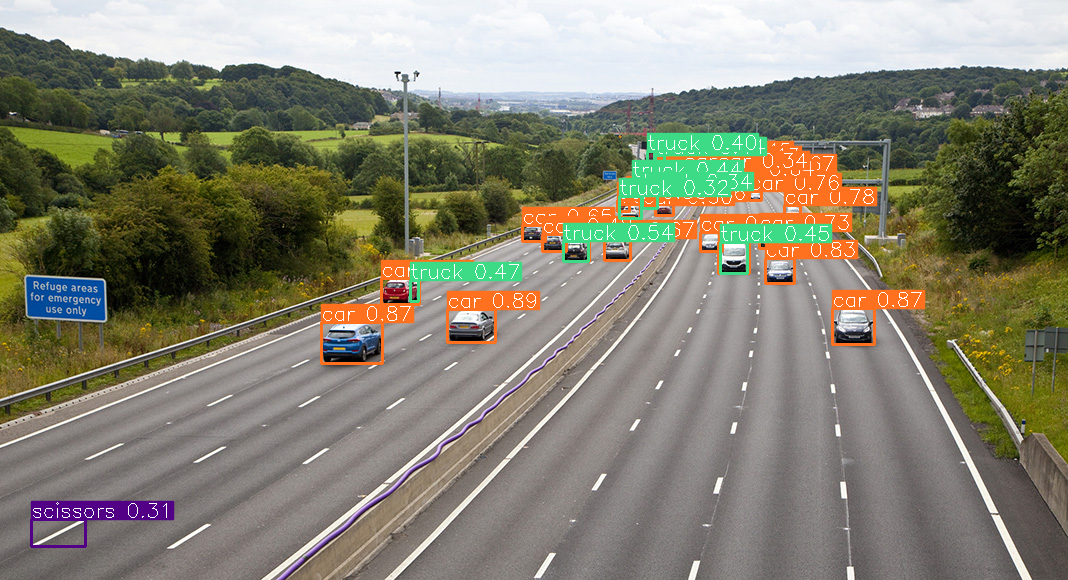

In [16]:
from sahi.predict import get_sliced_prediction
from sahi import AutoDetectionModel

from sahi.utils.yolov8 import download_yolov8s_model
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url

from IPython.display import Image

# Download sample image
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/small-vehicles1.jpeg', 'small-vehicles1.jpeg')

# Download YOLOv8 weights
model_path='yolov8s.pt'
download_yolov8s_model(model_path)

# Build YOLOv8 detector
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8', 
    model_path=model_path, 
    confidence_threshold=0.3,
    device='cpu'
)

# Perform sliced inference
result = get_sliced_prediction(
    read_image("small-vehicles1.jpeg"),
    detection_model,
    slice_height=256,
    slice_width=256,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2
)

# Save and display results
result.export_visuals(export_dir="./")
Image("./prediction_visual.png")

# Handling the Result

In a real application you probably want to use the results obtained by the sliced prediction. The following cell shows you how to read the prediction output. If you want to dig further, checkout [the source code](https://github.com/obss/sahi/blob/main/sahi/prediction.py).

Make sure you have run the cell above, as we are using the `result` object.

In [69]:
# The result is a list of predictions.
predictions = result.object_prediction_list
print(f'There were {len(predictions)} predictions!')

# Each prediction has its own bounding box in the form of: MinX, MinY, MaxX, MaxY
bbox = predictions[0].bbox
print(f"""The first prediction has a bounding box of:
  minx: {bbox.minx:.03f},
  miny: {bbox.miny:.03f},
  maxx: {bbox.maxx:.03f},
  maxy: {bbox.maxy:.03f}""")

# There's also an associated confidence score
score = predictions[0].score.value
print(f'The first prediction has a confidence of  box of: {score:.03f}')

# Finally, there's also a category, which is an integer and optionally a string
name = predictions[0].category.name
id = predictions[0].category.id
print(f'The first prediction is a {name} ({id})')

# Or you can just print the whole thing :)
print(predictions[0])

There were 17 predictions!
The first prediction has a bounding box of:
  minx: 447.736,
  miny: 309.286,
  maxx: 496.092,
  maxy: 341.952
The first prediction has a confidence of  box of: 0.777
The first prediction is a car (2)
ObjectPrediction<
    bbox: BoundingBox: <(447.7358, 309.2856, 496.0923, 341.95224), w: 48.356475830078125, h: 32.6666259765625>,
    mask: None,
    score: PredictionScore: <value: 0.7773550152778625>,
    category: Category: <id: 2, name: car>>


If you're already working with a well known annotation standard, then there are some utilities to export the prediction to:
* COCO (Annotation and Predictions)
* Imantics
* FiftyOne

In [40]:
# Print the first prediction in COCO format
result.to_coco_annotations()[0]

#result.to_coco_predictions(image_id=1)[0]
#result.to_imantics_annotations()[0]
#result.to_fiftyone_detections()[0]

{'image_id': None,
 'bbox': [447.6741943359375,
  309.5724792480469,
  48.0478515625,
  32.496734619140625],
 'score': 0.8857606649398804,
 'category_id': 2,
 'category_name': 'car',
 'segmentation': [],
 'iscrowd': 0,
 'area': 1561}

# Integration with Other Frameworks
Finally, here's an example on how you would use SAHI with other common frameworks such as OpenCV and Matplotlib. Of course, make sure you have them installed:

```bash
pip3 install opencv-python matplotlib
```

Performing prediction on 15 number of slices.


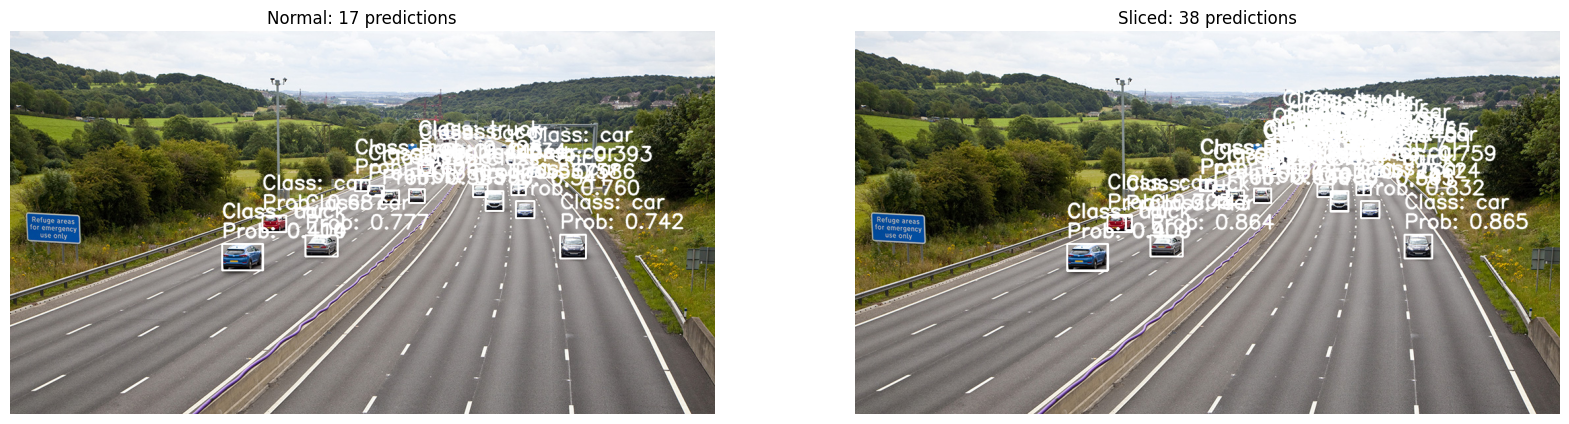

In [68]:
import cv2 as cv
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

from sahi.predict import get_sliced_prediction, get_prediction
from sahi import AutoDetectionModel
from sahi.utils.yolov8 import download_yolov8s_model

# Download YOLOv8 weights
model_path='yolov8s.pt'
download_yolov8s_model(model_path)

# Build YOLOv8 detector
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8', 
    model_path=model_path, 
    confidence_threshold=0.3,
    device='cpu'
)

img = cv.imread('small-vehicles1.jpeg')

# Just a helper to manually draw boxes
def draw_boxes(result, frame):
    predictions = result.object_prediction_list

    for prediction in predictions:
        bbox = prediction.bbox
        white = (255,255,255)

        x1 = int(bbox.minx)
        y1 = int(bbox.miny)
        x2 = int(bbox.maxx)
        y2 = int(bbox.maxy)
        cv.rectangle(frame, (x1, y1), (x2, y2), white, 2)
        cv.putText(frame, f"Class: {prediction.category.name}", (x1, y1 - 40), cv.FONT_HERSHEY_SIMPLEX, 1, white, 2, cv.LINE_AA)
        cv.putText(frame, f"Prob: {prediction.score.value:.03f}", (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 1, white, 2, cv.LINE_AA)

# Perform inference without slicing
result = get_prediction(
    img,
    detection_model
)

out = img.copy()
draw_boxes(result, out)

# Now perform sliced inference
sliced_result = get_sliced_prediction(
    img,
    detection_model,
    slice_height=256,
    slice_width=256,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2
)

out_sliced = img.copy()
draw_boxes(sliced_result, out_sliced)

# Display everything
plt.subplot(121)
plt.imshow(out[...,::-1])
plt.title(f'Normal: {len(result.object_prediction_list)} predictions')
plt.axis('off')
plt.subplot(122)
plt.imshow(out_sliced[...,::-1])
plt.title(f'Sliced: {len(sliced_result.object_prediction_list)} predictions')
plt.axis('off')

plt.show()
